## EuroSAT CNN Model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
from torch.utils.data import random_split
import sys
import os
# Suppress download messages
old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# Downloading and loading full dataset
full_dataset = datasets.EuroSAT(root='./data', 
                                 download=True, 
                                 transform=transform)

sys.stdout = old_stdout

# Split into train/val/test (70/15/15)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Creating data loaders
train_loader = DataLoader(train_dataset, 
                          batch_size=64, 
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=64,
                        shuffle=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=64, 
                         shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 18900
Validation samples: 4050
Test samples: 4050


In [5]:
image, label = train_dataset[0] # type: ignore

print(image.size())
print(f"Category label: {label}")

torch.Size([3, 64, 64])
Category label: 1


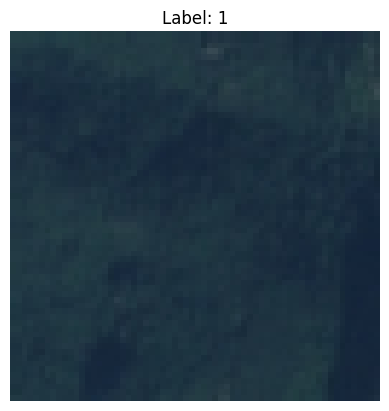

In [6]:
import matplotlib.pyplot as plt

img = image.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [7]:
classes = full_dataset.classes
print(classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=256 * 4 * 4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

        self.dropout = nn.Dropout(p=0.6)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [9]:
CNN_Model = CNNModel()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_Model.parameters(), lr=0.001)

In [10]:
# Test forward pass to see actual dimension
model = CNNModel()
x = torch.randn(1, 3, 32, 32)
x = model.pool(F.relu(model.conv1(x)))
x = model.pool(F.relu(model.conv2(x)))
x = model.pool(F.relu(model.conv3(x)))
x = model.pool(F.relu(model.conv4(x)))

print(x.shape)  # Will show you the actual dimensions
x = torch.flatten(x, 1)

print(x.shape)  # This is what fc1 should expect

torch.Size([1, 256, 2, 2])
torch.Size([1, 1024])


In [11]:
from torchinfo import summary
summary(CNN_Model, input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 64, 64]           896
├─MaxPool2d: 1-2                         [1, 32, 32, 32]           --
├─Conv2d: 1-3                            [1, 64, 32, 32]           18,496
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 128, 16, 16]          73,856
├─MaxPool2d: 1-6                         [1, 128, 8, 8]            --
├─Conv2d: 1-7                            [1, 256, 8, 8]            295,168
├─MaxPool2d: 1-8                         [1, 256, 4, 4]            --
├─Linear: 1-9                            [1, 512]                  2,097,664
├─Dropout: 1-10                          [1, 512]                  --
├─Linear: 1-11                           [1, 10]                   5,130
Total params: 2,491,210
Trainable params: 2,491,210
Non-train

In [12]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [13]:
print(f"Current device: {next(CNN_Model.parameters()).device}")

device = torch.device('mps')
print(f"Using device: {device}")

CNN_Model = CNN_Model.to(device)
print(f"Current device: {next(CNN_Model.parameters()).device}")

Current device: cpu
Using device: mps
Current device: mps:0


In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Tracing loss
        running_loss += loss.item()
        
        # Calculating accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculating average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
        
    return epoch_loss, epoch_acc

In [15]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track loss
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    return test_loss, test_acc

In [16]:
# Arrays to store metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# num_epochs = 10 //intial epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(CNN_Model, train_loader, loss_function, optimizer, device)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(CNN_Model, test_loader, loss_function, device)

    # Storing metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print("-" * 50)

Epoch [1/10]
Train Loss: 1.5409, Train Acc: 40.70%
Test Loss: 0.9768, Test Acc: 64.27%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.9238, Train Acc: 66.61%
Test Loss: 0.7651, Test Acc: 72.00%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.7577, Train Acc: 73.04%
Test Loss: 0.6778, Test Acc: 75.06%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.6789, Train Acc: 76.40%
Test Loss: 0.5615, Test Acc: 80.22%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.6164, Train Acc: 78.16%
Test Loss: 0.7017, Test Acc: 76.07%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.5535, Train Acc: 80.79%
Test Loss: 0.5082, Test Acc: 82.49%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.5096, Train Acc: 82.22%
Test Loss: 0.4480, Test Acc: 83.21%
--------------------------------------------------
Epoch [8/10]
Train Loss: 0.4704, T

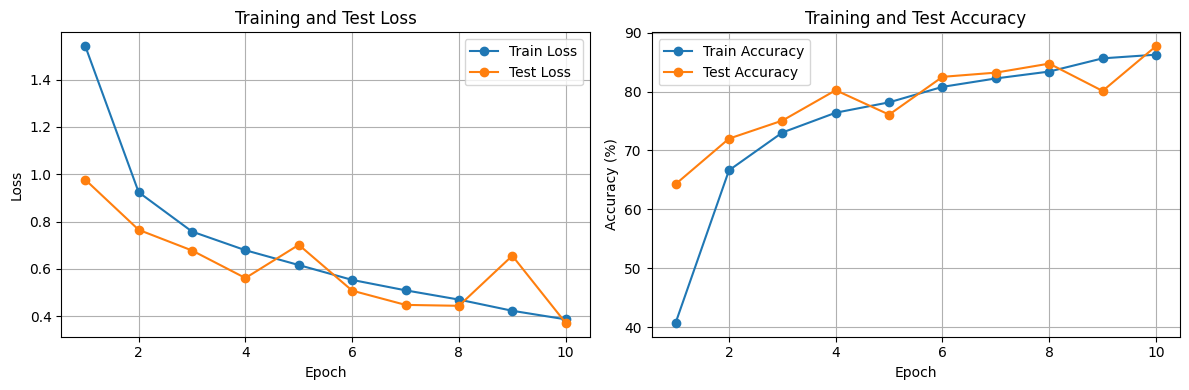

In [17]:
import matplotlib.pyplot as plt

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Loss over epochs
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), test_losses, label='Test Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Plot 2: Accuracy over epochs
ax2.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy', marker='o')
ax2.plot(range(1, num_epochs+1), test_accs, label='Test Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()